## Ice growth in the Beaufort Sea over the period 2000-2018

In [11]:
%matplotlib inline
import sys,os
sys.path.append('../src')
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from pynextsim.projection_info import ProjectionInfo
from brkup_utils import process_data
from brkup_utils import mask_funcs as msk
from brkup_utils.boxnames import *
from brkup_utils import grid_funcs as grd
from brkup_utils import calc_IceGrowth as ig


In [12]:
# set environment
os.environ['INPUT_OBS_DATA_DIR'] = '/home/rheinlender/shared-simstore-ns9829k/data/'
os.environ['NEXTSIM_MESH_DIR'] = os.environ['INPUT_OBS_DATA_DIR'] + 'mesh/'

# set directories
#era5_dir = '/home/rheinlender/shared-simstore-ns9829k/data/ERA5/'    
INDIR = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-ILBOXE140-S/'    

In [13]:
# read moorings 
mooring_fl = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-ILBOXE140-S/1995/nextsim/Moorings_1995m01.nc'
months = ['01', '02', '03']
years = list(range(2000, 2019))
region = 'Beaufort'
ds =  process_data.load_moorings(INDIR,months,years,region=region ,period=None)

months: ['01', '02', '03']
years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
bbox for Beaufort : (95, 225, 425, 575)
DONE!


In [14]:
##############################
# calculate masks
##############################
bbox = BOXNAMES[region]
Mask = msk.Masking(ds, bbox=bbox)
msk_moore22 = Mask.get_Moore2022_Beaufort_mask()

# remove land (nan-values) from Beaufort mask 
#ocn_mask = msk_moore22*(~np.isnan(ds['sic'][0]))
#plt.imshow(ocn_mask)

##############################
# Grid Info
##############################

# get area info from model grid and add to dataset
creg_grid = grd.CREGgrid('../grid_files', bbox)
ds['mod_area'] = (('y','x'), creg_grid.get_area())
ds['mod_area'].attrs = {'units':'m2', 'long_name':'grid_cell_area'}

# get land/ocean mask (1=ocn, 0=land) 
ds['tmask'] = ~ds.mod_area.isnull()  


# calculate ice growth

In [15]:
Igrowth = ig.IceGrowth(ds.copy())

Igrowth.fix_growthrate()

dVol = Igrowth.calc_vol_growth(msk_moore22)

total_growth = Igrowth.get_total_growth(dVol)


output frequency  4.0
newice
del_vi_thin
del_hi


In [16]:
years = np.unique(ds.time.dt.year)

plotdata = pd.DataFrame({
    "newice":(total_growth['newice']*1e-9),
    "young":(total_growth['del_vi_thin']*1e-9),
    "old":(total_growth['del_vi']*1e-9),
    }, 
    index=years
)

plotdata['total_growth'] = plotdata['newice'] + plotdata['young'] + plotdata['old']
plotdata['leadgrowth'] = plotdata['newice'] + plotdata['young'] # lead growth

# growth in leads and pack ice relative to total growth
leadgrowth_rel = (plotdata['leadgrowth']/plotdata['total_growth'])*100
oldgrowth_rel = (plotdata['old']/plotdata['total_growth'])*100

print(f'Rel. leadgrowth in 2000: {np.round(leadgrowth_rel[2000])}%')
print(f'Rel. leadgrowth in 2018: {np.round(leadgrowth_rel[2018])}%')

# check that it sums to 100%
print(leadgrowth_rel + oldgrowth_rel) 

Rel. leadgrowth in 2000: 29.0%
Rel. leadgrowth in 2018: 44.0%
2000    100.000000
2001    100.000000
2002    100.000000
2003    100.000000
2004    100.000000
2005    100.000000
2006    100.000000
2007    100.000000
2008    100.000000
2009    100.000000
2010    100.000008
2011    100.000008
2012    100.000000
2013    100.000000
2014    100.000008
2015    100.000000
2016    100.000000
2017    100.000000
2018    100.000000
dtype: float32


In [18]:
## Function to calculate and plot the linear trend in sea-ice lead growth

def plot_linearTrend(ax, df):
    
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    #%pip install pingouin
    import pingouin as pg

    # input variables for linear regression
    X = np.array(df.index)
    Y = np.array(df['leadgrowth']/(df['leadgrowth'] + df['old'])) *100   # relative lead growth

    X = X.reshape(-1, 1)
    Y = Y.reshape(-1, 1).flatten()
    
    print(Y)
    
    reg = LinearRegression()
    reg.fit(X,Y)
    params = np.append(reg.intercept_,reg.coef_)

    predictions = reg.predict(X)

    # get statistics from linear regression model (pengouin)
    reg_stats = pg.linear_regression(X , Y)

    #calculate R-squared of regression model
    r2 = reg_stats.r2[1]

    params = np.append(reg_stats.coef[0],reg_stats.coef[1])

    pval = reg_stats.pval[1]

    print("The linear model is: Y = {:.5} + {:.5}X".format(params[0], params[1]))
    print("r2:", r2)
    print("p-value:", pval)

    trend_lab = f'Trend: {np.round(params[1]*10, decimals=1)}% per decade'
    label = "r\u00b2 = {:.1f}% (p={:.3f})".format(r2*100, pval)
    
    ## Plotting
    ax.plot(X, Y, marker='o',linestyle='--',markersize=6,label='Growth in leads')
    ax.plot(X, predictions, c='grey', linewidth=2, label=trend_lab)

    ax.set_ylabel("Fraction of ice growth (%)")
    ax.grid( alpha=0.4, ls='--', zorder=1);
    #ax.set_title('Beaufort, JFM mean')
    ax.set_xticks(np.arange(2000, 2019,2))
    plt.legend()

    # annotate
    ax.text(0.6, 0.1, label, transform=ax.transAxes, fontsize=11, va='top', color='grey') 

# testing
#fig, ax = plt.subplots(1)
#plot_linearTrend(ax, df)

# Plot Figure 6

[28.69225  34.40151  30.223656 33.600655 33.803986 39.37651  38.615253
 32.96903  34.749565 37.471195 42.535175 33.52854  33.822277 42.49362
 40.21656  37.742455 41.936295 30.802341 43.693317]
The linear model is: Y = -852.23 + 0.4423X
r2: 0.3040918347243957
p-value: 0.014386671133100834
Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64')


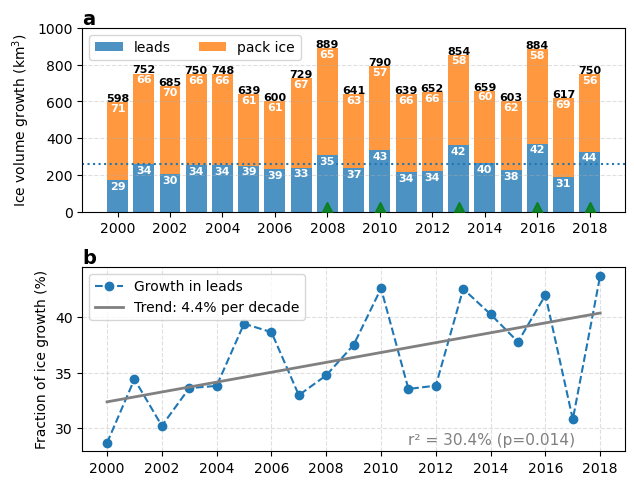

In [19]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(7, 5.5))
plt.subplots_adjust(hspace=0.3)
width = 0.8

# new dataframe 
df = plotdata[['leadgrowth', 'old']]

label_str = ['leads', 'pack ice']

# Initialize the bottom at zero for the first set of bars.
bottom = np.zeros(len(df))

# Plot each layer of the bar, adding each bar to the "bottom" so
# the next bar starts higher.
for i, col in enumerate(df.columns):
    ax0.bar(df.index, df[col], bottom=bottom, label=label_str[i], alpha=.8)
    bottom += np.array(df[col])

# add average lead growth
ax0.axhline(y=df['leadgrowth'].mean(axis=0), linestyle=':', color='tab:blue')
    
    
## Add totals
totals = df.sum(axis=1)
y_offset = 4

# Add labels to each bar.
for i, total in enumerate(totals):
    ax0.text(totals.index[i], total + y_offset, round(total), ha='center',
          weight='bold',  size=8)

## add relative growth   
y_offset = -50
for i, bar in enumerate(ax0.patches):
    xloc = round(bar.get_x()) # get year
    fractional_height = (bar.get_height()/plotdata['total_growth'][xloc])*100

    ax0.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() + y_offset,
      round(fractional_height),
      ha='center',
      color='w',
      weight='bold',
      size=8
    )    

ax0.set_ylim([0, 1000])
ax0.set_ylabel("Ice volume growth (km$^3$)")
ax0.grid(axis='y', alpha=0.4, ls='--', zorder=1);
#ax.set_title('Beaufort, JFM mean')
ax0.set_xticks(np.arange(2000, 2019,2))
ax0.legend(ncols=2)

##### LOWER SUBPLOT ######

plot_linearTrend(ax1, df)

ax0.text(-0.0, 1.1, 'a', transform=ax0.transAxes, fontsize=14, fontweight='bold', va='top')    
ax1.text(-0.0, 1.1, 'b', transform=ax1.transAxes,fontsize=14, fontweight='bold', va='top')
#plt.savefig(figdir+'LeadVolgrowth_moore22_JFM_barplotStacked_2000-2018.png', dpi=300, bbox_inches='tight')

# highlight breakup years
datelist = plotdata.index
print(datelist)
id_yrs = datelist[datelist.isin([2008, 2010, 2013, 2016, 2018])]
cbargs = {'color': 'green', 'alpha': 0.5, 'zorder':3, 'marker':"^", 'markersize': 15, 'ymax':0.}
[ax0.axvline(dto, **cbargs) for dto in id_yrs]


plt.savefig('../figures/' + 'fig06_iceVolgrowth_moore22_JFM_barplot_linearTrend_2000-2018.png', dpi=300, bbox_inches='tight')


In [ ]:
# plot total growth

#ax = plotdata['total_growth'].plot(kind='bar', stacked=False, figsize=(6, 2.5), zorder=2, width=0.5)
ax = plotdata['total_growth'].plot(figsize=(6, 2.5), marker='o', markersize=4)
ax.axhline(y=plotdata['total_growth'].mean(axis=0)+plotdata['total_growth'].std(axis=0), linestyle=':', color='grey')

ax.set_ylabel("JFM total growth (km$^3$)")

ax.grid(alpha=0.4, ls='--', zorder=1);
ax.set_xticks(np.arange(2000,2018+2,2))

#plt.savefig('Totalgrowth_moore22_JFM_2000-2018.png', dpi=300, bbox_inches='tight')
